In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, GaussianNoise, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
import seaborn as sns
from datetime import datetime
from tqdm.notebook import tqdm
import random
import zipfile
from google.colab import drive, files
import time

2025-06-01 20:06:51.048518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748808411.283137      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748808411.343948      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Kiểm tra GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
# Cố định seed
SEED = 1234
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
base_dir = '/kaggle/input/face-data-200'

In [5]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

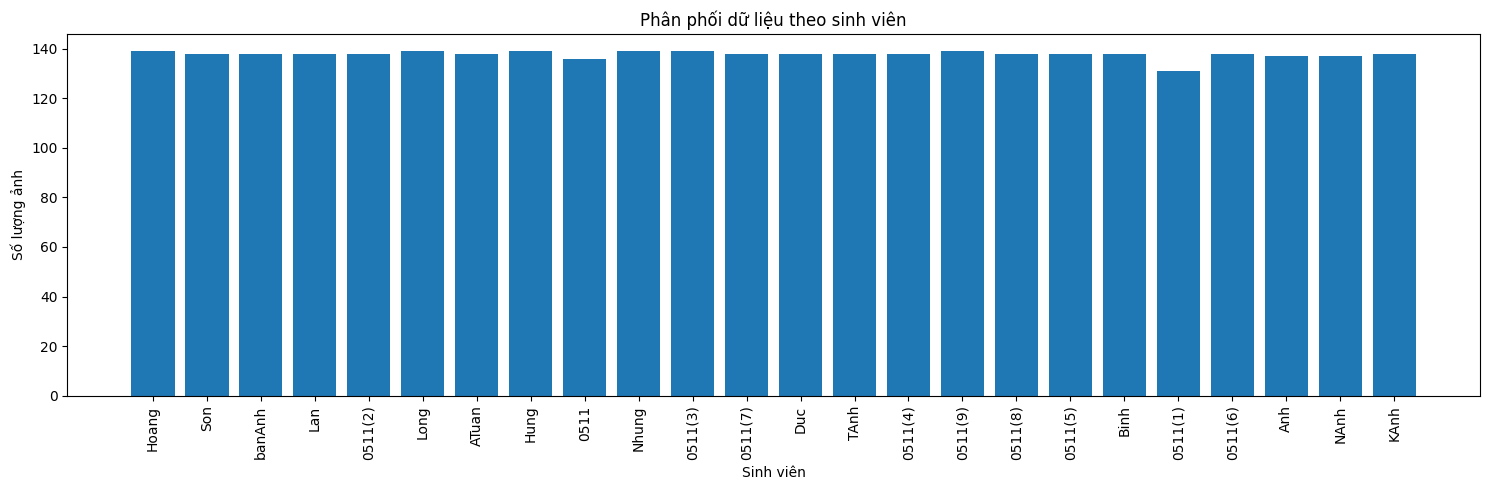

Số ảnh ít nhất: 131, nhiều nhất: 139


In [6]:
# Kiểm tra phân phối dữ liệu
student_counts = {}
for student_folder in os.listdir(train_dir):
    student_path = os.path.join(train_dir, student_folder)
    if os.path.isdir(student_path):
        images = [f for f in os.listdir(student_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        student_counts[student_folder] = len(images)

# Hiển thị phân phối
plt.figure(figsize=(15, 5))
plt.bar(student_counts.keys(), student_counts.values())
plt.xlabel('Sinh viên')
plt.ylabel('Số lượng ảnh')
plt.title('Phân phối dữ liệu theo sinh viên')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Nếu có sự mất cân bằng lớn, cân nhắc oversampling/undersampling
min_images = min(student_counts.values())
max_images = max(student_counts.values())
print(f"Số ảnh ít nhất: {min_images}, nhiều nhất: {max_images}")

In [7]:
# Kiểm tra cấu trúc dữ liệu
def check_data_structure(data_dir, type_name):
    if not os.path.exists(data_dir):
        print(f"Thư mục {type_name} không tồn tại: {data_dir}")
        return False

    class_dirs = os.listdir(data_dir)
    print(f"Thư mục {type_name} có {len(class_dirs)} lớp (sinh viên): {class_dirs}")

    total_images = 0
    class_distribution = {}

    for class_dir in class_dirs:
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            num_images = len(images)
            total_images += num_images
            class_distribution[class_dir] = num_images

    print(f"Tổng số ảnh trong {type_name}: {total_images}")
    print(f"Phân bố số lượng ảnh theo lớp: {class_distribution}\n")

    return True

In [8]:
train_ok = check_data_structure(train_dir, "train")
val_ok = check_data_structure(val_dir, "validation")
test_ok = check_data_structure(test_dir, "test")

Thư mục train có 24 lớp (sinh viên): ['Hoang', 'Son', 'banAnh', 'Lan', '0511(2)', 'Long', 'ATuan', 'Hung', '0511', 'Nhung', '0511(3)', '0511(7)', 'Duc', 'TAnh', '0511(4)', '0511(9)', '0511(8)', '0511(5)', 'Binh', '0511(1)', '0511(6)', 'Anh', 'NAnh', 'KAnh']
Tổng số ảnh trong train: 3307
Phân bố số lượng ảnh theo lớp: {'Hoang': 139, 'Son': 138, 'banAnh': 138, 'Lan': 138, '0511(2)': 138, 'Long': 139, 'ATuan': 138, 'Hung': 139, '0511': 136, 'Nhung': 139, '0511(3)': 139, '0511(7)': 138, 'Duc': 138, 'TAnh': 138, '0511(4)': 138, '0511(9)': 139, '0511(8)': 138, '0511(5)': 138, 'Binh': 138, '0511(1)': 131, '0511(6)': 138, 'Anh': 137, 'NAnh': 137, 'KAnh': 138}

Thư mục validation có 24 lớp (sinh viên): ['Hoang', 'Son', 'banAnh', 'Lan', '0511(2)', 'Long', 'ATuan', 'Hung', '0511', 'Nhung', '0511(3)', '0511(7)', 'Duc', 'TAnh', '0511(4)', '0511(9)', '0511(8)', '0511(5)', 'Binh', '0511(1)', '0511(6)', 'Anh', 'NAnh', 'KAnh']
Tổng số ảnh trong validation: 806
Phân bố số lượng ảnh theo lớp: {'Hoang': 3

In [9]:
# Cấu hình tham số
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 300
LEARNING_RATE = 0.001

In [10]:
# Tạo danh sách các lớp (mỗi lớp là một sinh viên)
classes = sorted(os.listdir(train_dir))
num_classes = len(classes)

print(f"Số lượng lớp: {num_classes}")
print(f"Các lớp: {classes}")

Số lượng lớp: 24
Các lớp: ['0511', '0511(1)', '0511(2)', '0511(3)', '0511(4)', '0511(5)', '0511(6)', '0511(7)', '0511(8)', '0511(9)', 'ATuan', 'Anh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh', 'banAnh']


In [11]:
# def add_salt_pepper_noise(image, noise_ratio=0.02):
#     """
#     Thêm Salt-and-Pepper noise vào ảnh (tối ưu cho khuôn mặt)
#     noise_ratio: tỷ lệ pixel bị nhiễu (0-1) - ĐIỀU CHỈNH TẠI ĐÂY
#     Khuyến nghị: 0.01-0.03 cho khuôn mặt
#     """
#     row, col, ch = image.shape
    
#     # Salt noise (white pixels)
#     num_salt = np.ceil(noise_ratio * image.size * 0.5)
#     coords = [np.random.randint(0, i, int(num_salt)) for i in image.shape[:2]]
#     image[coords[0], coords[1], :] = 1
    
#     # Pepper noise (black pixels)
#     num_pepper = np.ceil(noise_ratio * image.size * 0.5)
#     coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
#     image[coords[0], coords[1], :] = 0
    
#     return image

# def add_motion_blur(image, size=9):
#     """
#     Thêm Motion blur vào ảnh (tối ưu cho khuôn mặt)
#     size: kích thước kernel blur - ĐIỀU CHỈNH TẠI ĐÂY
#     Khuyến nghị: 5-15 cho khuôn mặt (không quá mạnh)
#     """
#     # Tạo motion blur kernel
#     kernel = np.zeros((size, size))
#     kernel[int((size-1)/2), :] = np.ones(size)
#     kernel = kernel / size
    
#     # Apply motion blur
#     blurred = cv2.filter2D(image, -1, kernel)
#     return blurred

# def add_gaussian_blur(image, kernel_size=3, sigma=0.8):
#     """
#     Thêm Gaussian blur vào ảnh (tối ưu cho khuôn mặt)
#     kernel_size: kích thước kernel (số lẻ) - ĐIỀU CHỈNH TẠI ĐÂY
#     sigma: độ lệch chuẩn - ĐIỀU CHỈNH TẠI ĐÂY
#     Khuyến nghị: kernel_size=3-7, sigma=0.5-1.5 cho khuôn mặt
#     """
#     if kernel_size % 2 == 0:
#         kernel_size += 1  # Đảm bảo kernel_size là số lẻ
    
#     blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
#     return blurred

# def custom_augmentation(image):
#     """
#     Hàm augmentation tùy chỉnh cho nhận diện khuôn mặt - ĐÃ SỬA LỖI ẢNH ĐEN
#     """
#     # Kiểm tra và đảm bảo ảnh có giá trị hợp lệ
#     if image is None or image.size == 0:
#         return image
    
#     # Đảm bảo ảnh có 3 channels
#     if len(image.shape) != 3:
#         return image
    
#     # Convert từ [0,1] về [0,255] để xử lý
#     original_range_01 = image.max() <= 1.0
#     if original_range_01:
#         image = (image * 255).astype(np.uint8)
    
#     try:
#         # 1. XÁC SUẤT ÁP DỤNG - ĐIỀU CHỈNH TẠI ĐÂY
#         if random.random() < 0.15:  # 15% chance
#             # 2. TỶ LỆ NHIỄU - ĐIỀU CHỈNH TẠI ĐÂY
#             noise_level = random.uniform(0.005, 0.02)
#             image = add_salt_pepper_noise(image.copy(), noise_ratio=noise_level)
        
#         if random.random() < 0.1:  # 10% chance
#             # 3. KÍCH THƯỚC MOTION BLUR - ĐIỀU CHỈNH TẠI ĐÂY
#             blur_size = random.randint(5, 11)
#             image = add_motion_blur(image.copy(), size=blur_size)
        
#         if random.random() < 0.1:  # 10% chance
#             # 4. THAM SỐ GAUSSIAN BLUR - ĐIỀU CHỈNH TẠI ĐÂY
#             kernel = random.choice([3, 5])
#             sigma_val = random.uniform(0.3, 1.0)
#             image = add_gaussian_blur(image.copy(), kernel_size=kernel, sigma=sigma_val)
    
#     except Exception as e:
#         print(f"Augmentation error: {e}")
#         # Trả về ảnh gốc nếu có lỗi
#         pass
    
#     # Convert về [0,1] range và đảm bảo không có giá trị âm
#     if original_range_01:
#         image = image.astype(np.float32) / 255.0
#         image = np.clip(image, 0.0, 1.0)  # Đảm bảo trong range [0,1]
    
#     return image

In [12]:
# # Data augmentation cho tập huấn luyện
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=10,
#     width_shift_range=0.05,
#     height_shift_range=0.05,
#     zoom_range=0.2,
#     shear_range=0.05,
#     horizontal_flip=True,  
#     brightness_range=[0.9, 1.1],
#     channel_shift_range=0.02,
#     fill_mode='nearest',
#     preprocessing_function=custom_augmentation
# )

# # Chỉ rescale cho tập validation và test
# val_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     shuffle=True
# )

# # # Thêm noise vào train generator
# # train_generator = NoiseGenerator(original_train_gen)

# val_generator = val_datagen.flow_from_directory(
#     val_dir,
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     shuffle=False
# )

# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     shuffle=False
# )

In [14]:
def load_image_paths_and_labels(root_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(root_dir))
    class_to_index = {cls_name: idx for idx, cls_name in enumerate(class_names)}

    for cls_name in class_names:
        cls_path = os.path.join(root_dir, cls_name)
        for fname in os.listdir(cls_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(cls_path, fname))
                labels.append(class_to_index[cls_name])

    return image_paths, labels, class_to_index

In [15]:
import os
import numpy as np
import cv2
import tensorflow as tf
import albumentations as A
from tensorflow.keras.utils import Sequence
from albumentations.core.composition import OneOf

class AlbumentationsDataGenerator(Sequence):
    def __init__(self, image_paths, labels, transform, batch_size=32, img_size=(224, 224), num_classes=2, shuffle=True, class_indices=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.classes = np.array(labels)
        self.samples = len(image_paths)
        self.class_indices = class_indices
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        for img_path in batch_paths:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.img_size)
            augmented = self.transform(image=image)
            images.append(augmented["image"])

        images = np.array(images, dtype=np.float32) / 255.0
        labels = tf.keras.utils.to_categorical(batch_labels, num_classes=self.num_classes)
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.image_paths, self.labels))
            np.random.shuffle(combined)
            self.image_paths, self.labels = zip(*combined)
    def reset(self):
        self.on_epoch_end()

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [16]:
def add_salt_and_pepper_noise(image, amount=0.01):
    """Thêm salt & pepper noise vào ảnh (image phải là numpy array dạng uint8)"""
    noisy = image.copy()
    h, w, c = noisy.shape
    num_salt = np.ceil(amount * h * w)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in noisy.shape[:2]]
    noisy[coords[0], coords[1]] = 255

    num_pepper = np.ceil(amount * h * w)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in noisy.shape[:2]]
    noisy[coords[0], coords[1]] = 0
    return noisy

In [17]:
# train_transform = A.Compose([
#     A.Resize(224, 224),
#     A.HorizontalFlip(p=0.1),
#     A.RandomBrightnessContrast(p=0.2),
#     A.OneOf([
#         A.MotionBlur(blur_limit=3, p=0.1),
#         A.GaussianBlur(blur_limit=3, p=0.1),
#         A.MedianBlur(blur_limit=3, p=0.1), 
#     ], p=0.3),
#     A.ImageCompression(quality_lower=85, quality_upper=100, p=0.2),
#     # A.CoarseDropout(max_holes=2, max_height=16, max_width=16, p=0.3),

#     A.Lambda(image=lambda x, **kwargs: add_salt_and_pepper_noise(x, amount=0.01), p=0.3),
# ])

# val_transform = A.Compose([
#     A.Resize(224, 224)
# ])

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.OneOf([
        A.MotionBlur(blur_limit=5, p=0.3),
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.MedianBlur(blur_limit=3, p=0.3), 
    ], p=0.5),
    A.OneOf([
        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.3),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    ], p=0.3),
    A.ImageCompression(quality_lower=85, quality_upper=100, p=0.2),
    # A.CoarseDropout(max_holes=2, max_height=16, max_width=16, p=0.3),

    A.Lambda(image=lambda x, **kwargs: add_salt_and_pepper_noise(x, amount=0.01), p=0.3),
])

val_transform = A.Compose([
    A.Resize(224, 224)
])

# demo_transform = A.ReplayCompose([
#     A.Resize(224, 224),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     A.OneOf([
#         A.MotionBlur(blur_limit=5, p=0.3),
#         A.GaussianBlur(blur_limit=(3, 5), p=0.3),
#         A.MedianBlur(blur_limit=3, p=0.3),
#     ], p=0.5),
#     A.OneOf([
#         A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.3),
#         A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
#     ], p=0.3),
#     A.ImageCompression(quality_lower=85, quality_upper=100, p=0.2),

/tmp/ipykernel_35/2445633901.py:31: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
/tmp/ipykernel_35/2445633901.py:33: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=85, quality_upper=100, p=0.2),
/tmp/ipykernel_35/2445633901.py:36: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: add_salt_and_pepper_noise(x, amount=0.01), p=0.3),


In [18]:
# Khởi tạo generator
train_image_paths, train_labels, class_to_index = load_image_paths_and_labels(train_dir)
val_image_paths, val_labels, _ = load_image_paths_and_labels(val_dir)
test_image_paths, test_labels, _ = load_image_paths_and_labels(test_dir)

num_classes = len(class_to_index)

train_generator = AlbumentationsDataGenerator(
    train_image_paths, 
    train_labels, 
    transform=train_transform, 
    num_classes=num_classes, 
    class_indices=class_to_index)

val_generator = AlbumentationsDataGenerator(
    val_image_paths, 
    val_labels, 
    transform=val_transform, 
    num_classes=num_classes, 
    shuffle=False, 
    class_indices=class_to_index)

test_generator = AlbumentationsDataGenerator(
    test_image_paths, 
    test_labels, 
    transform=val_transform, 
    num_classes=num_classes, 
    shuffle=False, 
    class_indices=class_to_index)

train_generator.class_indices = class_to_index

In [19]:
class_to_index

{'0511': 0,
 '0511(1)': 1,
 '0511(2)': 2,
 '0511(3)': 3,
 '0511(4)': 4,
 '0511(5)': 5,
 '0511(6)': 6,
 '0511(7)': 7,
 '0511(8)': 8,
 '0511(9)': 9,
 'ATuan': 10,
 'Anh': 11,
 'Binh': 12,
 'Duc': 13,
 'Hoang': 14,
 'Hung': 15,
 'KAnh': 16,
 'Lan': 17,
 'Long': 18,
 'NAnh': 19,
 'Nhung': 20,
 'Son': 21,
 'TAnh': 22,
 'banAnh': 23}

In [20]:
# import matplotlib.pyplot as plt
# import cv2
# import albumentations as A
# import numpy as np

# # Hàm thêm salt-and-pepper noise
# def add_salt_and_pepper_noise(image, amount=0.01):
#     noisy = image.copy()
#     h, w, c = noisy.shape
#     num_salt = int(amount * h * w)
#     num_pepper = int(amount * h * w)

#     coords = [np.random.randint(0, i, num_salt) for i in (h, w)]
#     noisy[coords[0], coords[1]] = 255

#     coords = [np.random.randint(0, i, num_pepper) for i in (h, w)]
#     noisy[coords[0], coords[1]] = 0

#     return noisy

# # Dùng ReplayCompose để ghi lại các augmentation đã áp dụng
# demo_transform = A.ReplayCompose([
#     A.Resize(224, 224),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     A.OneOf([
#         A.MotionBlur(blur_limit=5, p=0.3),
#         A.GaussianBlur(blur_limit=(3, 5), p=0.3),
#         A.MedianBlur(blur_limit=3, p=0.3),
#     ], p=0.5),
#     A.OneOf([
#         A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.3),
#         A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
#     ], p=0.3),
#     A.ImageCompression(quality_lower=85, quality_upper=100, p=0.2),
    
#     # Sửa lỗi bằng cách thêm 'name'
#     A.Lambda(
#         name='salt_and_pepper',
#         image=lambda x, **kwargs: add_salt_and_pepper_noise(x, amount=0.01),
#         p=0.5
#     ),
# ])


# # Đọc ảnh đầu vào
# img_path = "/kaggle/input/face-data-200/train/0511(2)/face_001_q2.30_c0.jpg"
# image = cv2.imread(img_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Áp dụng augmentation và lưu lại log
# augmented = demo_transform(image=image)
# augmented_image = augmented["image"]
# replay_info = augmented["replay"]

# # Hàm lấy danh sách augmentation đã được thực thi
# def get_applied_augmentations(replay):
#     def extract_names(transform_dict):
#         names = []
#         if 'transforms' in transform_dict:
#             for t in transform_dict['transforms']:
#                 if t['applied']:
#                     if 'transforms' in t:  # OneOf or Compose bên trong
#                         names += extract_names(t)
#                     else:
#                         names.append(t['__class_fullname__'].split('.')[-1])
#         return names
#     return extract_names(replay)

# # Lấy danh sách các augmentation đã áp dụng
# applied_augs = get_applied_augmentations(replay_info)
# title_text = "Đã áp dụng: " + ", ".join(applied_augs) if applied_augs else "Không áp dụng augmentation nào"

# # Hiển thị ảnh
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(image)
# plt.title("Ảnh gốc")
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(augmented_image)
# plt.title(title_text, fontsize=10)
# plt.axis('off')

# plt.tight_layout()
# plt.show()


In [21]:
import json

# Giả sử bạn đã có class_to_index từ load_image_paths_and_labels()
with open('class_indices.json', 'w', encoding='utf-8') as f:
    json.dump(class_to_index, f, ensure_ascii=False, indent=4)

In [22]:
# Tính toán class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Tính toán class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 1.0131740196078431, 1: 1.0518447837150127, 2: 0.9984903381642513, 3: 0.9913069544364509, 4: 0.9984903381642513, 5: 0.9984903381642513, 6: 0.9984903381642513, 7: 0.9984903381642513, 8: 0.9984903381642513, 9: 0.9913069544364509, 10: 0.9984903381642513, 11: 1.005778588807786, 12: 0.9984903381642513, 13: 0.9984903381642513, 14: 0.9913069544364509, 15: 0.9913069544364509, 16: 0.9984903381642513, 17: 0.9984903381642513, 18: 0.9913069544364509, 19: 1.005778588807786, 20: 0.9913069544364509, 21: 0.9984903381642513, 22: 0.9984903381642513, 23: 0.9984903381642513}


In [23]:
def show_batch(image_batch, label_batch, class_indices):
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    plt.figure(figsize=(10, 10))
    for i in range(min(25, len(image_batch))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i])

        # Lấy index của lớp được dự đoán (argmax)
        class_idx = np.argmax(label_batch[i])
        class_name = idx_to_class[class_idx]

        plt.title(class_name, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [24]:
images, labels = next(iter(train_generator))

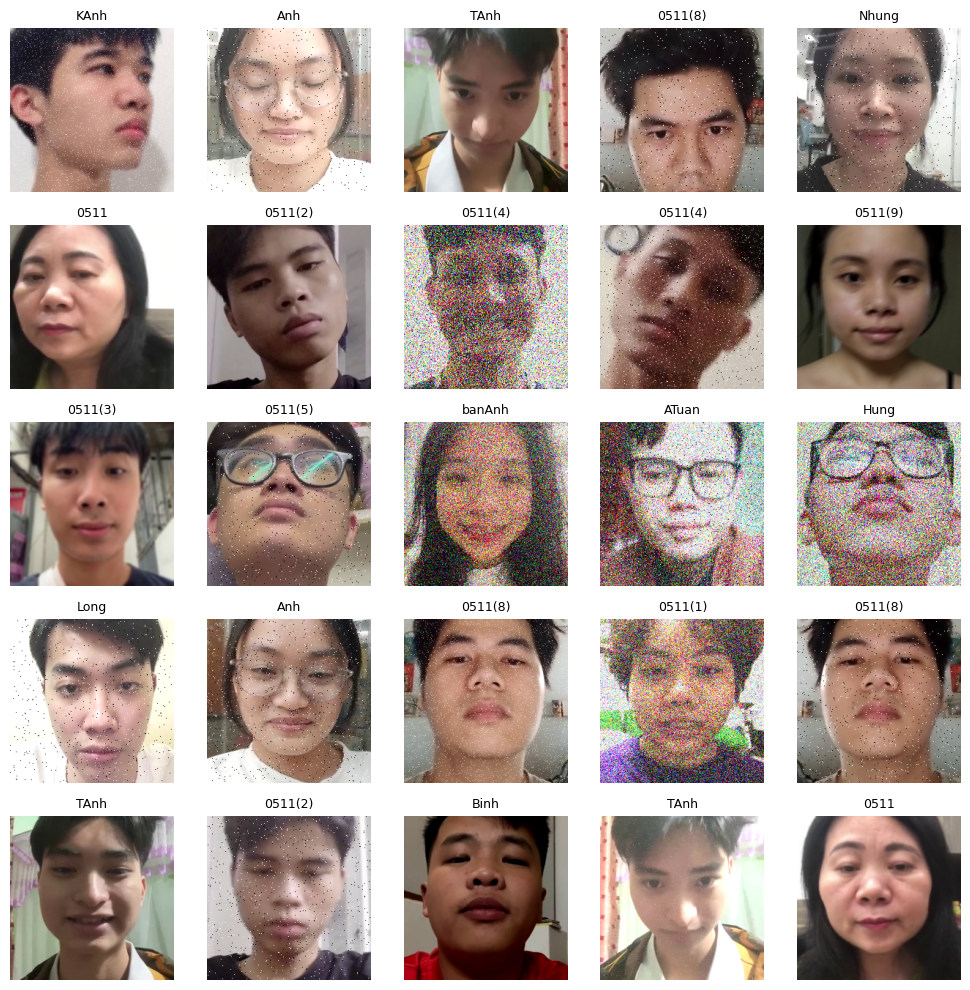

In [25]:
show_batch(images, labels, train_generator.class_indices)

# Build Model

In [26]:
def build_model(num_classes):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = GaussianNoise(0.03)(inputs)

    # Truyền input đã thêm noise vào base_model
    base_model = MobileNetV2(
        input_tensor=x,
        include_top=False,
        weights='imagenet'
    )

    # Đóng băng các lớp (tuỳ mức fine-tune)
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    # Head classifier
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=predictions)

    return model, base_model

In [27]:
# Tạo mô hình
model, base_model = build_model(num_classes)

I0000 00:00:1748808432.961541      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748808432.962301      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/tmp/ipykernel_35/1078242138.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gaussian_noise            │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ gaussian_noise[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise    

 Total params: 4,111,960 (15.69 MB)

 Trainable params: 2,583,896 (9.86 MB)

 Non-trainable params: 1,528,064 (5.83 MB)

# Huấn luyện mô hình - Giai đoạn 1: Train lớp top

In [30]:
# Thư mục để lưu mô hình
model_dir = '/kaggle/working/models'
os.makedirs(model_dir, exist_ok=True)

In [31]:
# Tạo tên mô hình với timestamp
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = f"face_recognition_model_{timestamp}"
model_path = os.path.join(model_dir, model_name)
os.makedirs(model_path, exist_ok=True)

In [32]:
# Callbacks
checkpoint = ModelCheckpoint(
    os.path.join(model_path, 'best_model_stage1.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

tensorboard = TensorBoard(
    log_dir=os.path.join(model_path, 'logs'),
    histogram_freq=1
)

callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard]

In [33]:
# Tính số bước trên mỗi epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

In [34]:
# Huấn luyện model - Giai đoạn 1 (chỉ train các lớp top mới thêm vào)
start = time.time()
history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300


I0000 00:00:1748808447.016122     101 service.cc:148] XLA service 0x78a674003ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748808447.017182     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748808447.017205     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748808448.204030     101 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748808455.686850     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.5375 - loss: 3.7371

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.23250, saving model to /kaggle/working/models/face_recognition_model_20250601-200715/best_model_stage1.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 61s 404ms/step - accuracy: 0.5390 - loss: 3.7302 - val_accuracy: 0.2325 - val_loss: 9.2648 - learning_rate: 0.0010
Epoch 2/300
  1/103 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7812 - loss: 2.5411

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.23250 to 0.24375, saving model to /kaggle/working/models/face_recognition_model_20250601-200715/best_model_stage1.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7812 - loss: 2.5411 - val_accuracy: 0.2438 - val_loss: 9.1562 - learning_rate: 0.0010
Epoch 3/300
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8415 - loss: 2.3906
Epoch 3: val_accuracy improved from 0.24375 to 0.45875, saving model to /kaggle/working/models/face_recognition_model_20250601-200715/best_model_stage1.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.8415 - loss: 2.3900 - val_accuracy: 0.4588 - val_loss: 10.7300 - learning_rate: 0.0010
Epoch 4/300
  1/103 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9062 - loss: 2.0592
Epoch 4: val_accuracy did not improve from 0.45875
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9062 - loss: 2.0592 - val_accuracy: 0.4313 - val_loss: 11.0608 - learning_rate: 0.0010
Epoch 5/300
103/103 ━━━━━━━━━━━

# Fine-tuning - Giai đoạn 2: Tinh chỉnh một số lớp của mô hình cơ sở

In [35]:
# Mở khóa các lớp cuối của base model
# Đóng băng các lớp đầu, mở khóa các lớp cuối để fine-tune
for layer in base_model.layers[:-50]:  # Giữ các lớp đầu đóng băng
    layer.trainable = False
for layer in base_model.layers[-50:]:  # Mở khóa 30 lớp cuối
    layer.trainable = True

In [36]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE / 10),  # Learning rate thấp hơn cho fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
# Cập nhật callbacks cho giai đoạn 2
checkpoint_stage2 = ModelCheckpoint(
    os.path.join(model_path, 'best_model_stage2.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks_stage2 = [checkpoint_stage2, early_stopping, reduce_lr, tensorboard]

In [38]:
# Huấn luyện giai đoạn 2 - Fine-tuning
history_stage2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=200,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_stage2,
    class_weight=class_weight_dict,
    verbose=1
)

end = time.time()
print(f"Thời gian huấn luyện: {end - start:.2f} giây")

Epoch 1/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9335 - loss: 0.7802
Epoch 1: val_accuracy improved from -inf to 0.96500, saving model to /kaggle/working/models/face_recognition_model_20250601-200715/best_model_stage2.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 269ms/step - accuracy: 0.9336 - loss: 0.7796 - val_accuracy: 0.9650 - val_loss: 0.6052 - learning_rate: 1.0000e-04
Epoch 2/200
  1/103 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 1.0000 - loss: 0.5449
Epoch 2: val_accuracy did not improve from 0.96500
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 1.0000 - loss: 0.5449 - val_accuracy: 0.9650 - val_loss: 0.6065 - learning_rate: 1.0000e-04
Epoch 3/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9682 - loss: 0.6216
Epoch 3: val_accuracy improved from 0.96500 to 0.97750, saving model to /kaggle/working/models/face_recognition_model_20250601-200715/best_model_stage2.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.9683 - loss: 0.6214 - va

# Đánh giá mô hình trên tập test

In [39]:
# Tải model tốt nhất
best_model_path = os.path.join(model_path, 'best_model_stage2.h5')
model = load_model(best_model_path)

In [40]:
# Đánh giá trên tập test
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - accuracy: 0.9973 - loss: 0.4819
Test accuracy: 0.9984
Test loss: 0.4795


In [41]:
from sklearn.metrics import classification_report

# Dự đoán
y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)

# Nhãn thực tế
test_labels = np.array(test_generator.labels[:len(y_pred_classes)])

# Danh sách class indices (tất cả 24 lớp)
class_indices = test_generator.class_indices
sorted_classes = sorted(class_indices.items(), key=lambda x: x[1])
target_names = [name for name, _ in sorted_classes]
all_class_ids = [idx for _, idx in sorted_classes]

# Classification report cho tất cả lớp
print(classification_report(
    test_labels,
    y_pred_classes,
    labels=all_class_ids,
    target_names=target_names,
    zero_division=0  # tránh chia cho 0 nếu có lớp không xuất hiện
))

21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step
              precision    recall  f1-score   support

        0511       1.00      1.00      1.00        28
     0511(1)       1.00      1.00      1.00        26
     0511(2)       1.00      1.00      1.00        29
     0511(3)       1.00      1.00      1.00        28
     0511(4)       1.00      0.96      0.98        28
     0511(5)       1.00      1.00      1.00        28
     0511(6)       1.00      1.00      1.00        28
     0511(7)       1.00      1.00      1.00        28
     0511(8)       1.00      1.00      1.00        28
     0511(9)       1.00      1.00      1.00        27
       ATuan       1.00      1.00      1.00        28
         Anh       1.00      1.00      1.00        28
        Binh       1.00      1.00      1.00        28
         Duc       0.97      1.00      0.98        28
       Hoang       1.00      1.00      1.00        28
        Hung       1.00      1.00      1.00        28
        KAnh       1.00      1.00      

In [42]:
test_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  8,  8,  8

In [45]:
class_indices

{'0511': 0,
 '0511(1)': 1,
 '0511(2)': 2,
 '0511(3)': 3,
 '0511(4)': 4,
 '0511(5)': 5,
 '0511(6)': 6,
 '0511(7)': 7,
 '0511(8)': 8,
 '0511(9)': 9,
 'ATuan': 10,
 'Anh': 11,
 'Binh': 12,
 'Duc': 13,
 'Hoang': 14,
 'Hung': 15,
 'KAnh': 16,
 'Lan': 17,
 'Long': 18,
 'NAnh': 19,
 'Nhung': 20,
 'Son': 21,
 'TAnh': 22,
 'banAnh': 23}

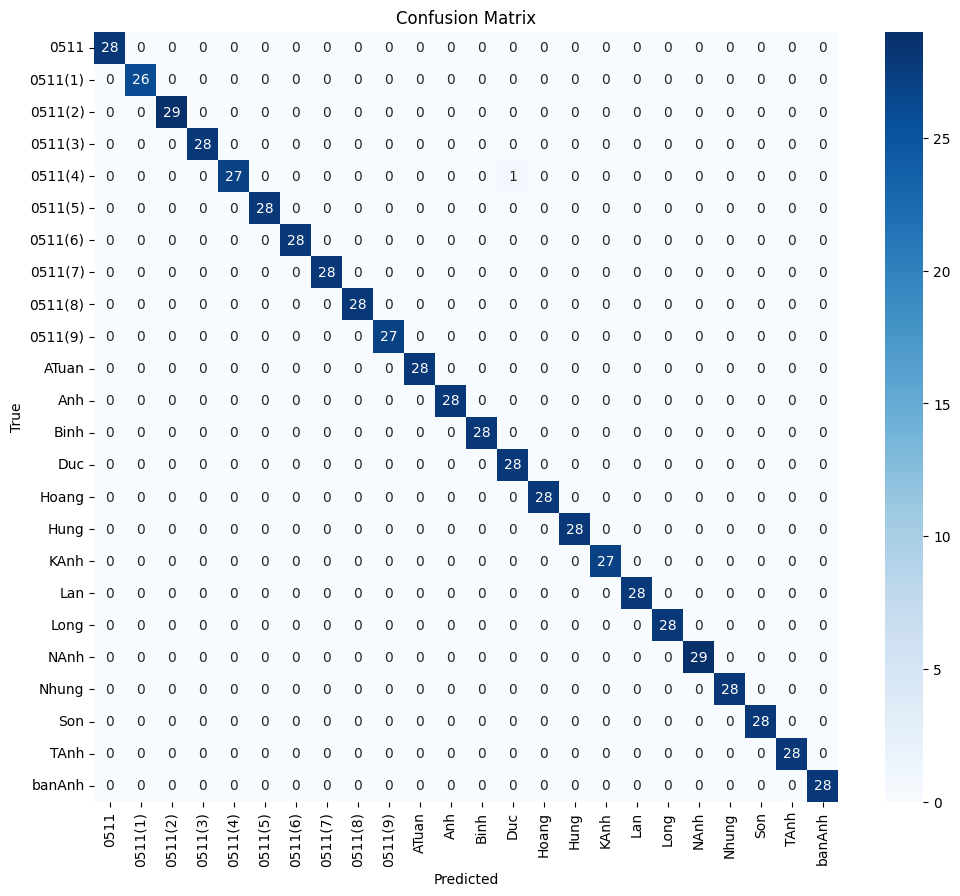

In [47]:
# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_labels, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_indices, yticklabels=class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Unique labels in test set:", np.unique(test_generator.labels))
print("Total expected classes:", len(test_generator.class_indices))


# Hiển thị các kết quả dự đoán

In [50]:
def show_prediction_examples(test_generator, model, class_indices, num_examples=10):
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Reset generator
    test_generator.reset()

    # Lấy các batch cho đến khi đủ số lượng ví dụ
    examples = []
    count = 0

    for i in range(min(50, len(test_generator))):
        if count >= num_examples:
            break

        x_batch, y_batch = next(iter(test_generator))
        y_pred_batch = model.predict(x_batch)

        for j in range(len(x_batch)):
            if count >= num_examples:
                break

            true_class_idx = np.argmax(y_batch[j])
            pred_class_idx = np.argmax(y_pred_batch[j])
            confidence = y_pred_batch[j][pred_class_idx]

            is_correct = true_class_idx == pred_class_idx

            examples.append({
                'image': x_batch[j],
                'true_class': idx_to_class[true_class_idx],
                'pred_class': idx_to_class[pred_class_idx],
                'confidence': confidence,
                'is_correct': is_correct
            })

            count += 1

    # Hiển thị các ví dụ
    plt.figure(figsize=(15, 4 * num_examples//5 + 4))

    for i, example in enumerate(examples):
        ax = plt.subplot(num_examples//5 + 1, 5, i + 1)

        plt.imshow(example['image'])

        title_color = 'green' if example['is_correct'] else 'red'
        plt.title(
            f"True: {example['true_class']}\nPred: {example['pred_class']}\nConf: {example['confidence']:.2f}",
            color=title_color,
            fontsize=9
        )

        plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


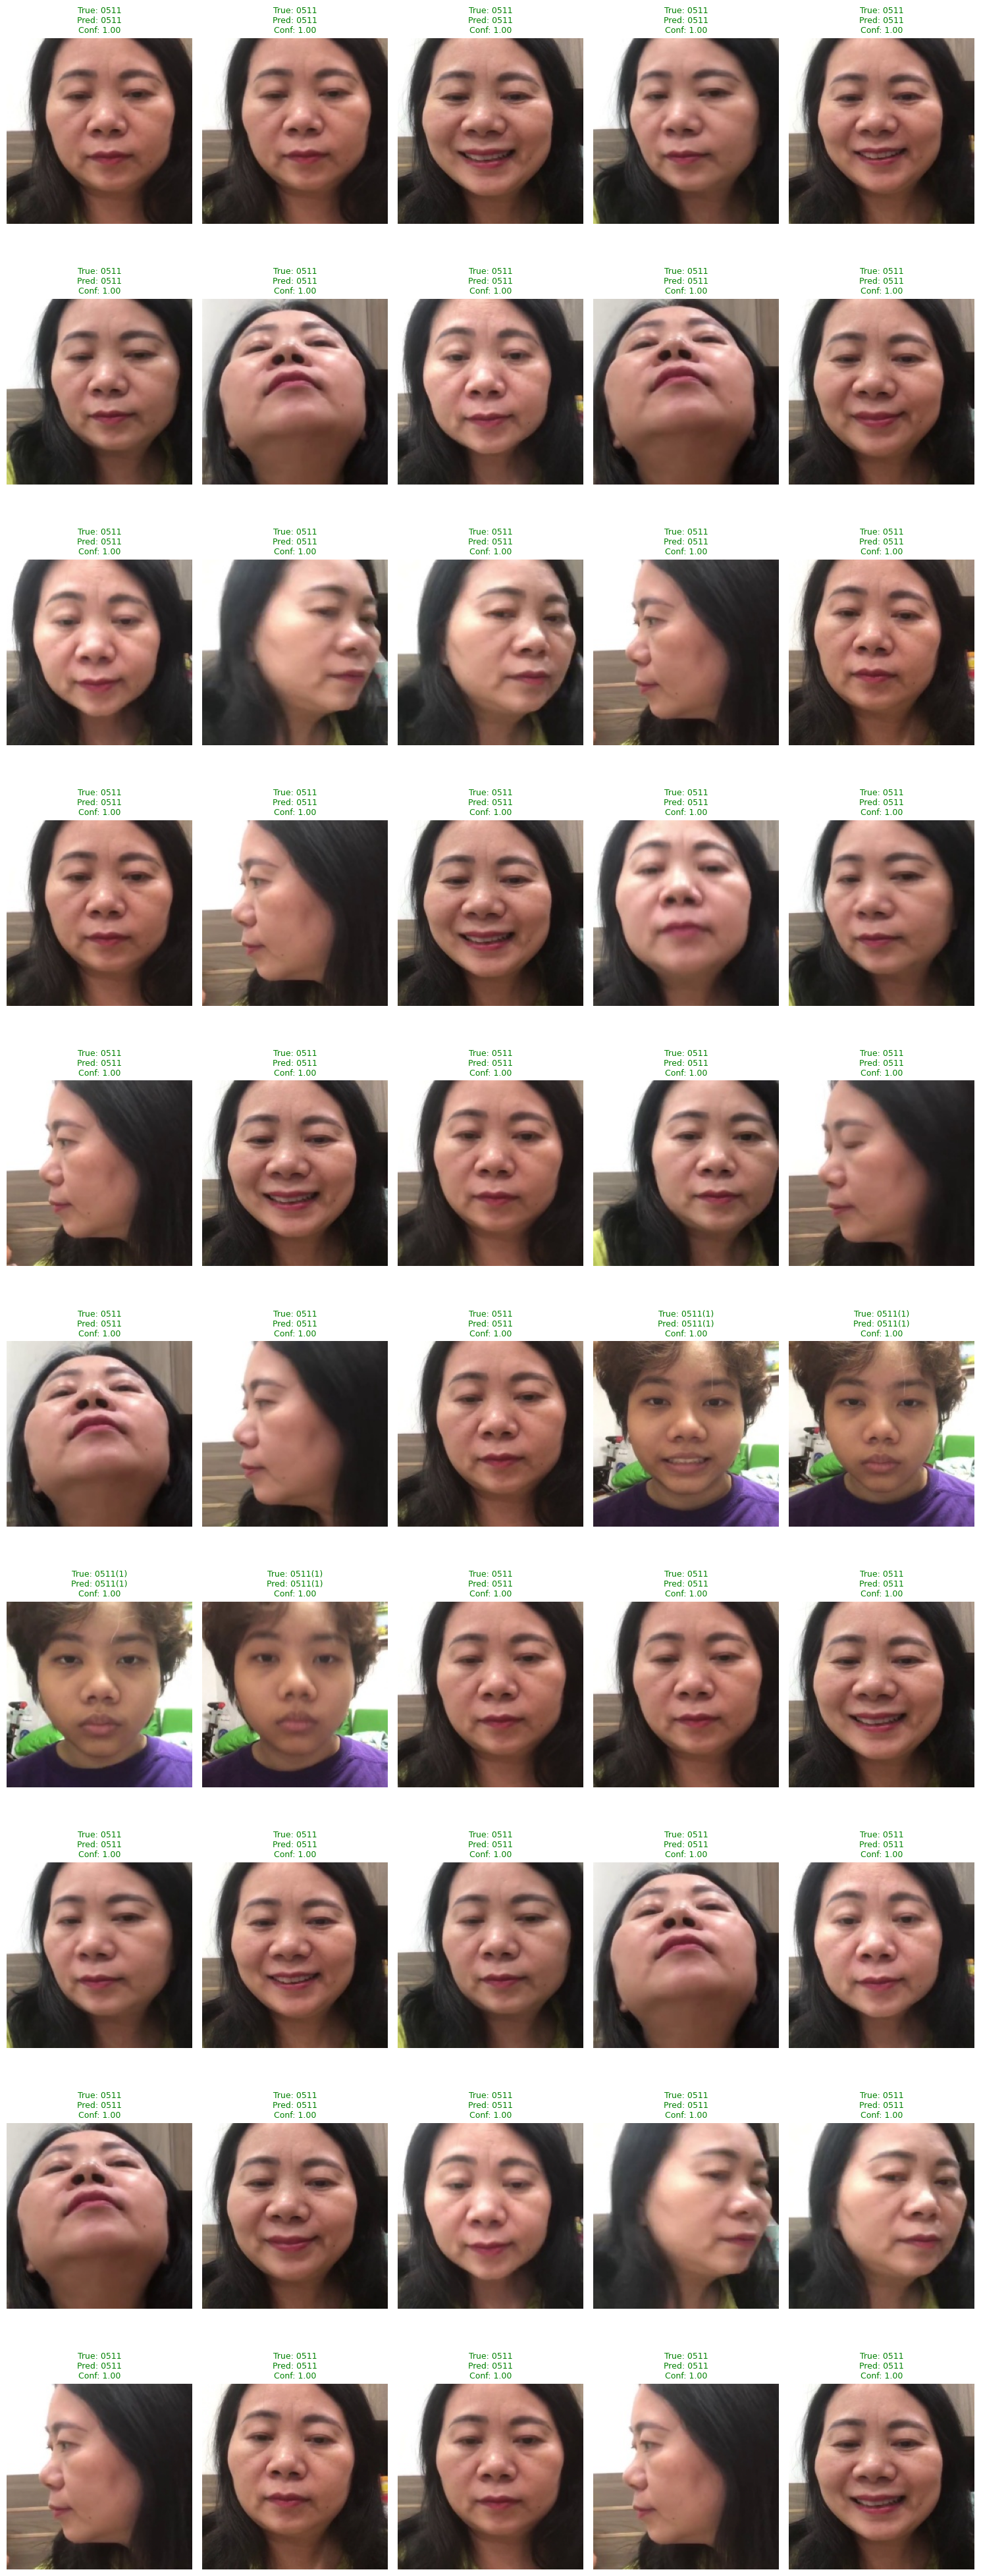

In [51]:
show_prediction_examples(test_generator, model, test_generator.class_indices, num_examples=50)

In [53]:
def show_incorrect_predictions(test_generator, model, class_indices, num_examples=15):
    """
    Hiển thị các ví dụ dự đoán sai từ tập test

    Args:
        test_generator: Generator cho tập test
        model: Mô hình đã huấn luyện
        class_indices: Dictionary ánh xạ tên lớp thành index
        num_examples: Số lượng ví dụ sai muốn hiển thị
    """
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Reset generator
    test_generator.reset()

    # Danh sách lưu các dự đoán sai
    incorrect_examples = []

    # Duyệt qua tập test để tìm các dự đoán sai
    for i in range(len(test_generator)):
        x_batch, y_batch = next(iter(test_generator))
        y_pred_batch = model.predict(x_batch)

        for j in range(len(x_batch)):
            true_class_idx = np.argmax(y_batch[j])
            pred_class_idx = np.argmax(y_pred_batch[j])

            # Kiểm tra nếu dự đoán sai
            if true_class_idx != pred_class_idx:
                confidence = y_pred_batch[j][pred_class_idx]

                incorrect_examples.append({
                    'image': x_batch[j],
                    'true_class': idx_to_class[true_class_idx],
                    'pred_class': idx_to_class[pred_class_idx],
                    'confidence': confidence
                })

                # Nếu đã đủ số lượng ví dụ, dừng vòng lặp
                if len(incorrect_examples) >= num_examples:
                    break

        # Nếu đã đủ số lượng ví dụ, dừng vòng lặp
        if len(incorrect_examples) >= num_examples:
            break

    if not incorrect_examples:
        print("Không có dự đoán sai nào được tìm thấy trong tập test!")
        return

    total_found = len(incorrect_examples)
    print(f"Tìm thấy {total_found} dự đoán sai. Hiển thị tối đa {min(num_examples, total_found)} ví dụ:")

    # Hiển thị các ví dụ sai
    rows = (min(num_examples, total_found) // 3) + (1 if min(num_examples, total_found) % 3 > 0 else 0)
    plt.figure(figsize=(15, 5 * rows))

    for i, example in enumerate(incorrect_examples[:num_examples]):
        ax = plt.subplot(rows, 3, i + 1)

        plt.imshow(example['image'])

        plt.title(
            f"True: {example['true_class']}\nPred: {example['pred_class']}\nConf: {example['confidence']:.2f}",
            color='red',
            fontsize=10
        )

        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Thực thi hàm để hiển thị các dự đoán sai
print("Hiển thị các dự đoán sai trên tập test:")
show_incorrect_predictions(test_generator, model, test_generator.class_indices, num_examples=15)

Hiển thị các dự đoán sai trên tập test:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Không có dự đoán sai nào được tìm thấy trong tập test!


# Vẽ đồ thị quá trình huấn luyện

In [54]:
def plot_training_history(history1, history2=None, title="Training History"):
    plt.figure(figsize=(15, 5))

    # Đồ thị accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Stage 1 Train')
    plt.plot(history1.history['val_accuracy'], label='Stage 1 Validation')


    # Tiếp tục từ đoạn code trước
    if history2:
        # Xác định điểm bắt đầu của stage 2
        stage1_epochs = len(history1.history['accuracy'])
        x_stage2 = range(stage1_epochs, stage1_epochs + len(history2.history['accuracy']))

        plt.plot(x_stage2, history2.history['accuracy'], label='Stage 2 Train')
        plt.plot(x_stage2, history2.history['val_accuracy'], label='Stage 2 Validation')

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Đồ thị loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Stage 1 Train')
    plt.plot(history1.history['val_loss'], label='Stage 1 Validation')

    if history2:
        plt.plot(x_stage2, history2.history['loss'], label='Stage 2 Train')
        plt.plot(x_stage2, history2.history['val_loss'], label='Stage 2 Validation')

    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

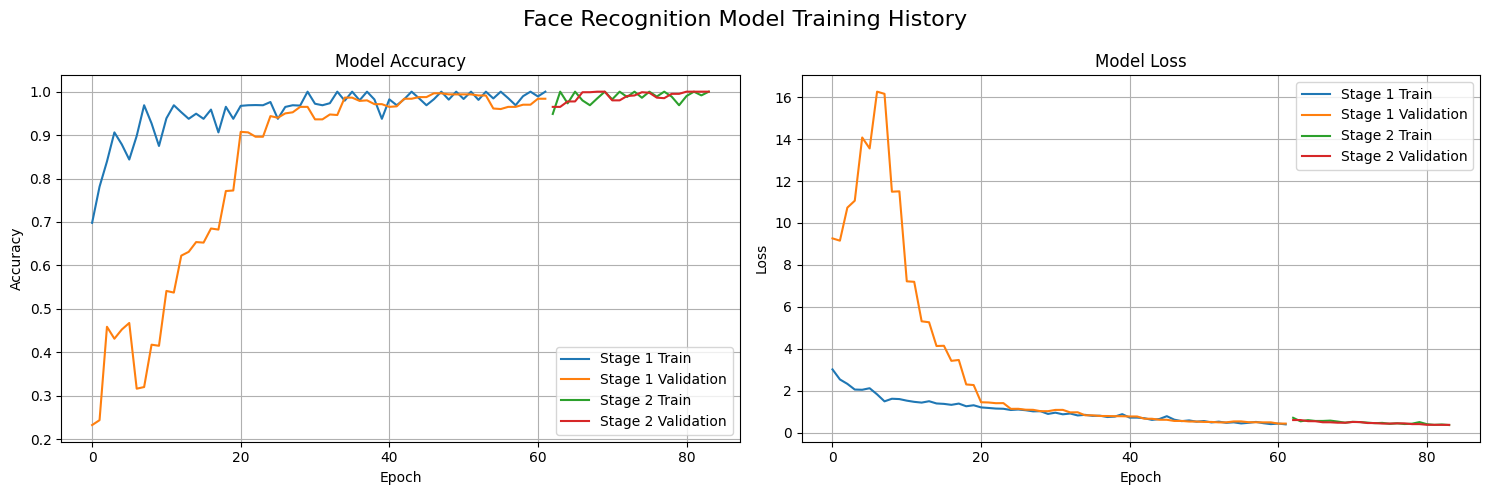

In [55]:
plot_training_history(history_stage1, history_stage2, "Face Recognition Model Training History")

In [56]:
import pickle
with open(os.path.join(model_path, 'history.pkl'), 'wb') as f:
    pickle.dump({
        'stage1': history_stage1.history,
        'stage2': history_stage2.history
    }, f)

In [57]:
import tensorflow as tf

# Bước 1: Load mô hình .h5
model = tf.keras.models.load_model(best_model_path)

# Bước 2: Chuyển sang định dạng TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Bước 3: Lưu lại file .tflite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("Chuyển đổi thành công!")

Saved artifact at '/tmp/tmp5p0l2z88'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  132657731447376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657731445264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657731448144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657731446224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657731451792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657731445840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657731443344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657731446608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657731450064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657731448720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13265773144430

W0000 00:00:1748809714.247315      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748809714.247350      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1748809714.380663      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
